# Probabilistic Linear Inference on Direct Sum with Discontinuity

## Overview

This notebook demonstrates **Bayesian linear inverse problems** on a composite model space consisting of:
- **Two Sobolev spaces**: representing smooth P-wave velocity ($v_p$) and S-wave velocity ($v_s$)
- **One Euclidean space**: representing a discontinuity location parameter

This extends the standard multi-component Sobolev inference by adding a scalar parameter representing a physical discontinuity (e.g., layer boundary, interface depth).

## The Mathematical Framework

### Model Space Structure

The complete model space is a **hierarchical direct sum**:

$$\mathcal{M} = (H^s([0,R]) \oplus H^s([0,R])) \oplus \mathbb{R}$$

where:
- $H^s([0,R])$ are Sobolev spaces for velocity fields
- $\mathbb{R}$ represents the discontinuity location
- $R$ is Earth's radius (6371 km)

### Forward Problem

We observe noisy data through a linear operator:
$$\mathbf{\tilde{d}} = G(m) + \bm{\eta}, \quad m = (m_{vp}, m_{vs}, m_{\text{disc}})$$

where:
- $G = (G_{vp}, G_{vs}, G_{\text{disc}})$ is the block-structured forward operator
- $\bm{\eta} \sim \mathcal{N}(0, \mathbf{C}_{\mathcal{D}})$ is additive Gaussian noise

### Property Inference

We target **local properties** rather than the full model:
$$\mathcal{T}: \mathcal{M} \to \mathcal{P} \cong \mathbb{R}^{N_p}$$

The property operator $\mathcal{T}$ extracts local averages (bump function projections) from the velocity fields, while the discontinuity parameter has zero influence on properties in this example.

### Bayesian Solution

**Prior**: Block-diagonal Gaussian measure
$$\mu_{\mathcal{M}}^0 = \mathcal{N}(m_0, C_0), \quad C_0 = \text{diag}(C_{vp}, C_{vs}, C_{\text{disc}})$$

**Posterior**: 
$$\mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\tilde{m}, C_{\mathcal{M}})$$

where:
$$C_{\mathcal{M}} = (G^* \mathbf{C}_{\mathcal{D}}^{-1} G + C_0^{-1})^{-1}, \quad \tilde{m} = C_{\mathcal{M}}(G^* \mathbf{C}_{\mathcal{D}}^{-1} \mathbf{\tilde{d}} + C_0^{-1}m_0)$$

**Property Posterior**: Push-forward of model posterior
$$\mu_{\mathcal{P}} = \mathcal{T}_* \mu_{\mathcal{M}}^{\mathbf{\tilde{d}}} = \mathcal{N}(\mathcal{T}(\tilde{m}), \mathcal{T} C_{\mathcal{M}} \mathcal{T}^*)$$

## Key Features

1. **Multi-scale inference**: Simultaneously infers smooth fields and discrete parameters
2. **Operator balancing**: Ensures all model components contribute meaningfully to data
3. **Efficient computation**: Option to skip full model posterior for faster property inference
4. **Bessel-Sobolev priors**: Flexible smoothness control via spectral methods

In [118]:
from pygeoinf.interval import( IntervalDomain, Sobolev,
BesselSobolev, Laplacian, Lebesgue, BoundaryConditions, SobolevSpaceDirectSum,
SOLAOperator, Function)
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider, NullFunctionProvider
from pygeoinf import EuclideanSpace, HilbertSpaceDirectSum, RowLinearOperator, LinearOperator, GaussianMeasure
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Set-up folder for saving figures
import os
figures_folder = 'pli_realistic_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [119]:
# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================

# Set to True to compute and visualize the model posterior
# Set to False to skip model posterior and go directly to property posterior
COMPUTE_MODEL_POSTERIOR = False

print(f"Configuration:")
print(f"  COMPUTE_MODEL_POSTERIOR = {COMPUTE_MODEL_POSTERIOR}")
if COMPUTE_MODEL_POSTERIOR:
    print("  → Will compute model posterior, then push to property space")
else:
    print("  → Will skip model posterior and compute property posterior directly")
    print("  → Expected speedup: ~4-5x faster")

Configuration:
  COMPUTE_MODEL_POSTERIOR = False
  → Will skip model posterior and compute property posterior directly
  → Expected speedup: ~4-5x faster


In [120]:
# Define the domain for the model (Earth's radius in km)
function_domain = IntervalDomain(0, 6371)

# ===== Setup Vp (P-wave velocity) Sobolev space =====
# Create Lebesgue measure as base space for Vp
M_lebesgue = Lebesgue(0, function_domain)

# Set Neumann boundary conditions for Vp (zero derivative at boundaries)
bcs_vp = BoundaryConditions(bc_type='neumann')

# Define Laplacian operator with regularization parameter alpha
alpha_vp = 1.0
L_vp = Laplacian(M_lebesgue, bcs_vp, alpha_vp)

# Create Sobolev space for Vp with 20 basis functions
# s=1, k=1 defines the smoothness and order of the Sobolev space
N_d_vp = 20
s, k = 1, 1
M_vp = Sobolev(N_d_vp, function_domain, s, k, L_vp)

# ===== Setup Vs (S-wave velocity) Sobolev space =====
# Create Lebesgue measure as base space for Vs
M_lebesgue = Lebesgue(0, function_domain)

# Set Neumann boundary conditions for Vs (zero derivative at boundaries)
bcs_vs = BoundaryConditions(bc_type='neumann')

# Define Laplacian operator with regularization parameter alpha
alpha_vs = 1.0
L_vs = Laplacian(M_lebesgue, bcs_vs, alpha_vs)

# Create Sobolev space for Vs with 20 basis functions
N_d_vs = 20
s, k = 1, 1
M_vs = Sobolev(N_d_vs, function_domain, s, k, L_vs)

# ===== Setup discontinuity parameter space =====
# 1D Euclidean space for modeling a single discontinuity location
M_discontinuity = EuclideanSpace(1)

# ===== Combine all spaces into final model space =====
# Direct sum of Vp and Vs Sobolev spaces
M_sobolev = SobolevSpaceDirectSum([M_vp, M_vs])

# Complete model space: smooth velocity fields + discontinuity location
M = HilbertSpaceDirectSum([M_sobolev, M_discontinuity])

# Data and property spaces
N_d = 50  # number of data points
D = EuclideanSpace(N_d)  # data space
N_p = 20  # number of property points
P = EuclideanSpace(N_p)  # property space


In [121]:
# =============================================================================
# Forward and Property Operators Configuration
# =============================================================================

# Target function parameters
# NOTE: width is in absolute units (km), not fraction of domain!
# For Earth radius of 6371 km, a reasonable bump width might be 200-500 km
width = 500.0  # Width of bump target functions in km
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p)

print(f"Target configuration:")
print(f"  Bump width: {width} km")
print(f"  Number of targets: {N_p}")
print(f"  Center spacing: {(centers[1] - centers[0]):.1f} km")
print(f"  First center: {centers[0]:.1f} km")
print(f"  Last center: {centers[-1]:.1f} km")

# ===== Forward Operators (Data Space) =====
# These map from model space to data space (observations)

# Create normal modes providers for the forward operators
# These generate complex sensitivity kernels using combinations of basis functions
# Note: random_state ensures reproducibility
normal_modes_provider_vp = NormalModesProvider(
    M_vp,
    n_modes_range=(1, 50),          # Use 1-50 modes for each kernel
    coeff_range=(-5, 5),             # Coefficient range for mode combinations
    gaussian_width_percent_range=(1, 5),  # Width as percentage of domain
    freq_range=(0.1, 20),            # Frequency range for oscillations
    random_state=2,                  # For reproducibility
)
normal_modes_provider_vs = NormalModesProvider(
    M_vs,
    n_modes_range=(1, 50),
    coeff_range=(-5, 5),
    gaussian_width_percent_range=(1, 5),
    freq_range=(0.1, 20),
    random_state=3,                  # Different seed for independent kernels
)

def discontinuity_forward_operator_mapping(x):
    """Forward mapping for discontinuity location to data space."""
    # Sensitivity constant - adjust to balance contributions from all components
    # Higher values = discontinuity has more influence on data
    K_d = 100.0  # Sensitivity constant for discontinuity location
    return K_d * x

# Create forward operators for each component
G_vp = SOLAOperator(M_vp, D, normal_modes_provider_vp)
G_vs = SOLAOperator(M_vs, D, normal_modes_provider_vs)
G_func = RowLinearOperator([G_vp, G_vs])
G_discontinuity = LinearOperator(M_discontinuity, D,
                                 discontinuity_forward_operator_mapping)

# Combine into single forward operator from full model space to data space
G = RowLinearOperator([G_func, G_discontinuity])

# ===== Property Operators (Target Space) =====
# These define what we want to recover (local averages, specific features, etc.)

# Target providers: bump functions for Vp, null for Vs
target_provider_vp = BumpFunctionProvider(M_vp, centers=centers, default_width=width)
target_provider_vs = NullFunctionProvider(M_vs)  # No target for Vs

def discontinuity_property_operator_mapping(x):
    """Property mapping for discontinuity - set to zero (not a target property)."""
    K_p = 0.0  # Zero sensitivity = not a target property
    return K_p * x

# Create property operators for each component
T_vp = SOLAOperator(M_vp, P, target_provider_vp)
T_vs = SOLAOperator(M_vs, P, target_provider_vs)
T_func = RowLinearOperator([T_vp, T_vs])
T_discontinuity = LinearOperator(M_discontinuity, P,
                                 discontinuity_property_operator_mapping)

# Combine into single property operator from model space to property space
T = RowLinearOperator([T_func, T_discontinuity])

print(f"\nOperators created successfully:")
print(f"  Forward operator G: {M.dim} → {D.dim}")
print(f"  Property operator T: {M.dim} → {P.dim}")

Target configuration:
  Bump width: 500.0 km
  Number of targets: 20
  Center spacing: 309.0 km
  First center: 250.0 km
  Last center: 6121.0 km

Operators created successfully:
  Forward operator G: 41 → 50
  Property operator T: 41 → 20


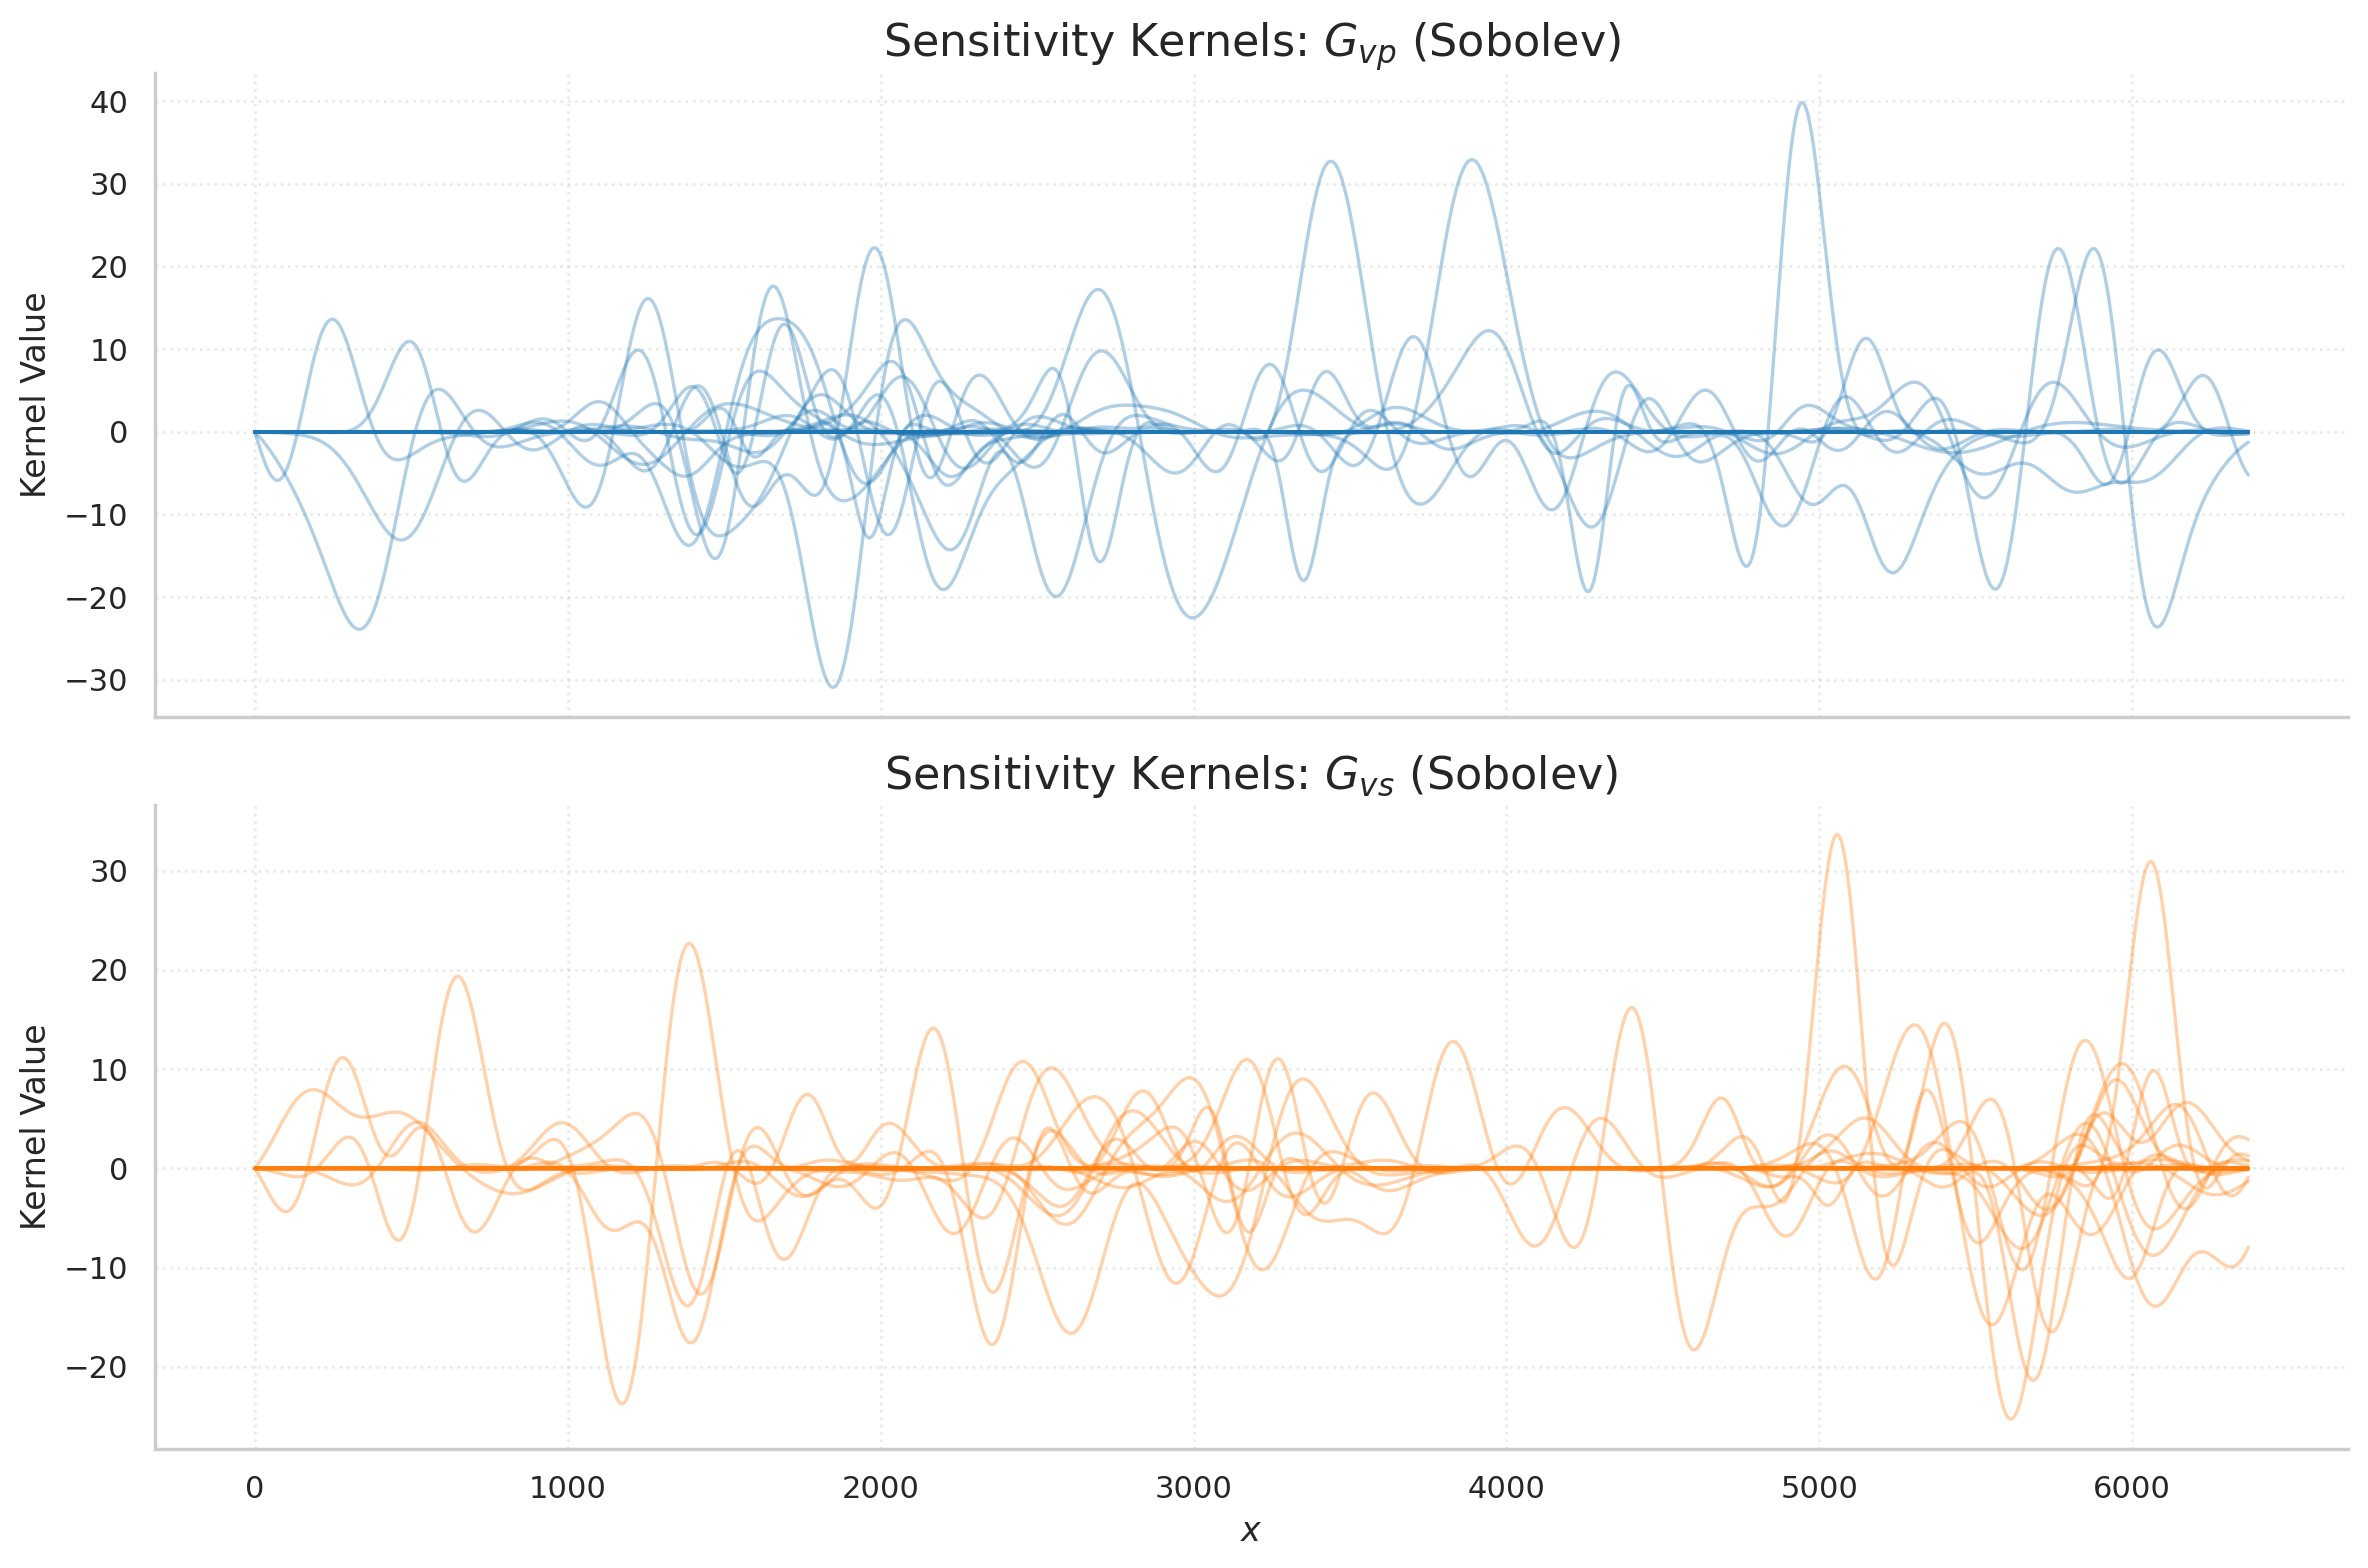

In [122]:
# Sensitivity Kernels figure
fig_title = "Sensitivity Kernels (vp & vs - Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

x = np.linspace(function_domain.a, function_domain.b, 1000)

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Create two vertically stacked subplots: top for G_vp, bottom for G_vs
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top subplot: G_vp kernels
axs[0].set_title(r"Sensitivity Kernels: $G_{vp}$ (Sobolev)", fontsize=16)
for i in range(N_d):
    axs[0].plot(
        x,
        G_vp.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.35,
        linewidth=1.2,
    )
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom subplot: G_vs kernels
axs[1].set_title(r"Sensitivity Kernels: $G_{vs}$ (Sobolev)", fontsize=16)
for i in range(N_d):
    axs[1].plot(
        x,
        G_vs.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.35,
        linewidth=1.2,
    )
axs[1].set_xlabel(r"$x$", fontsize=12)
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

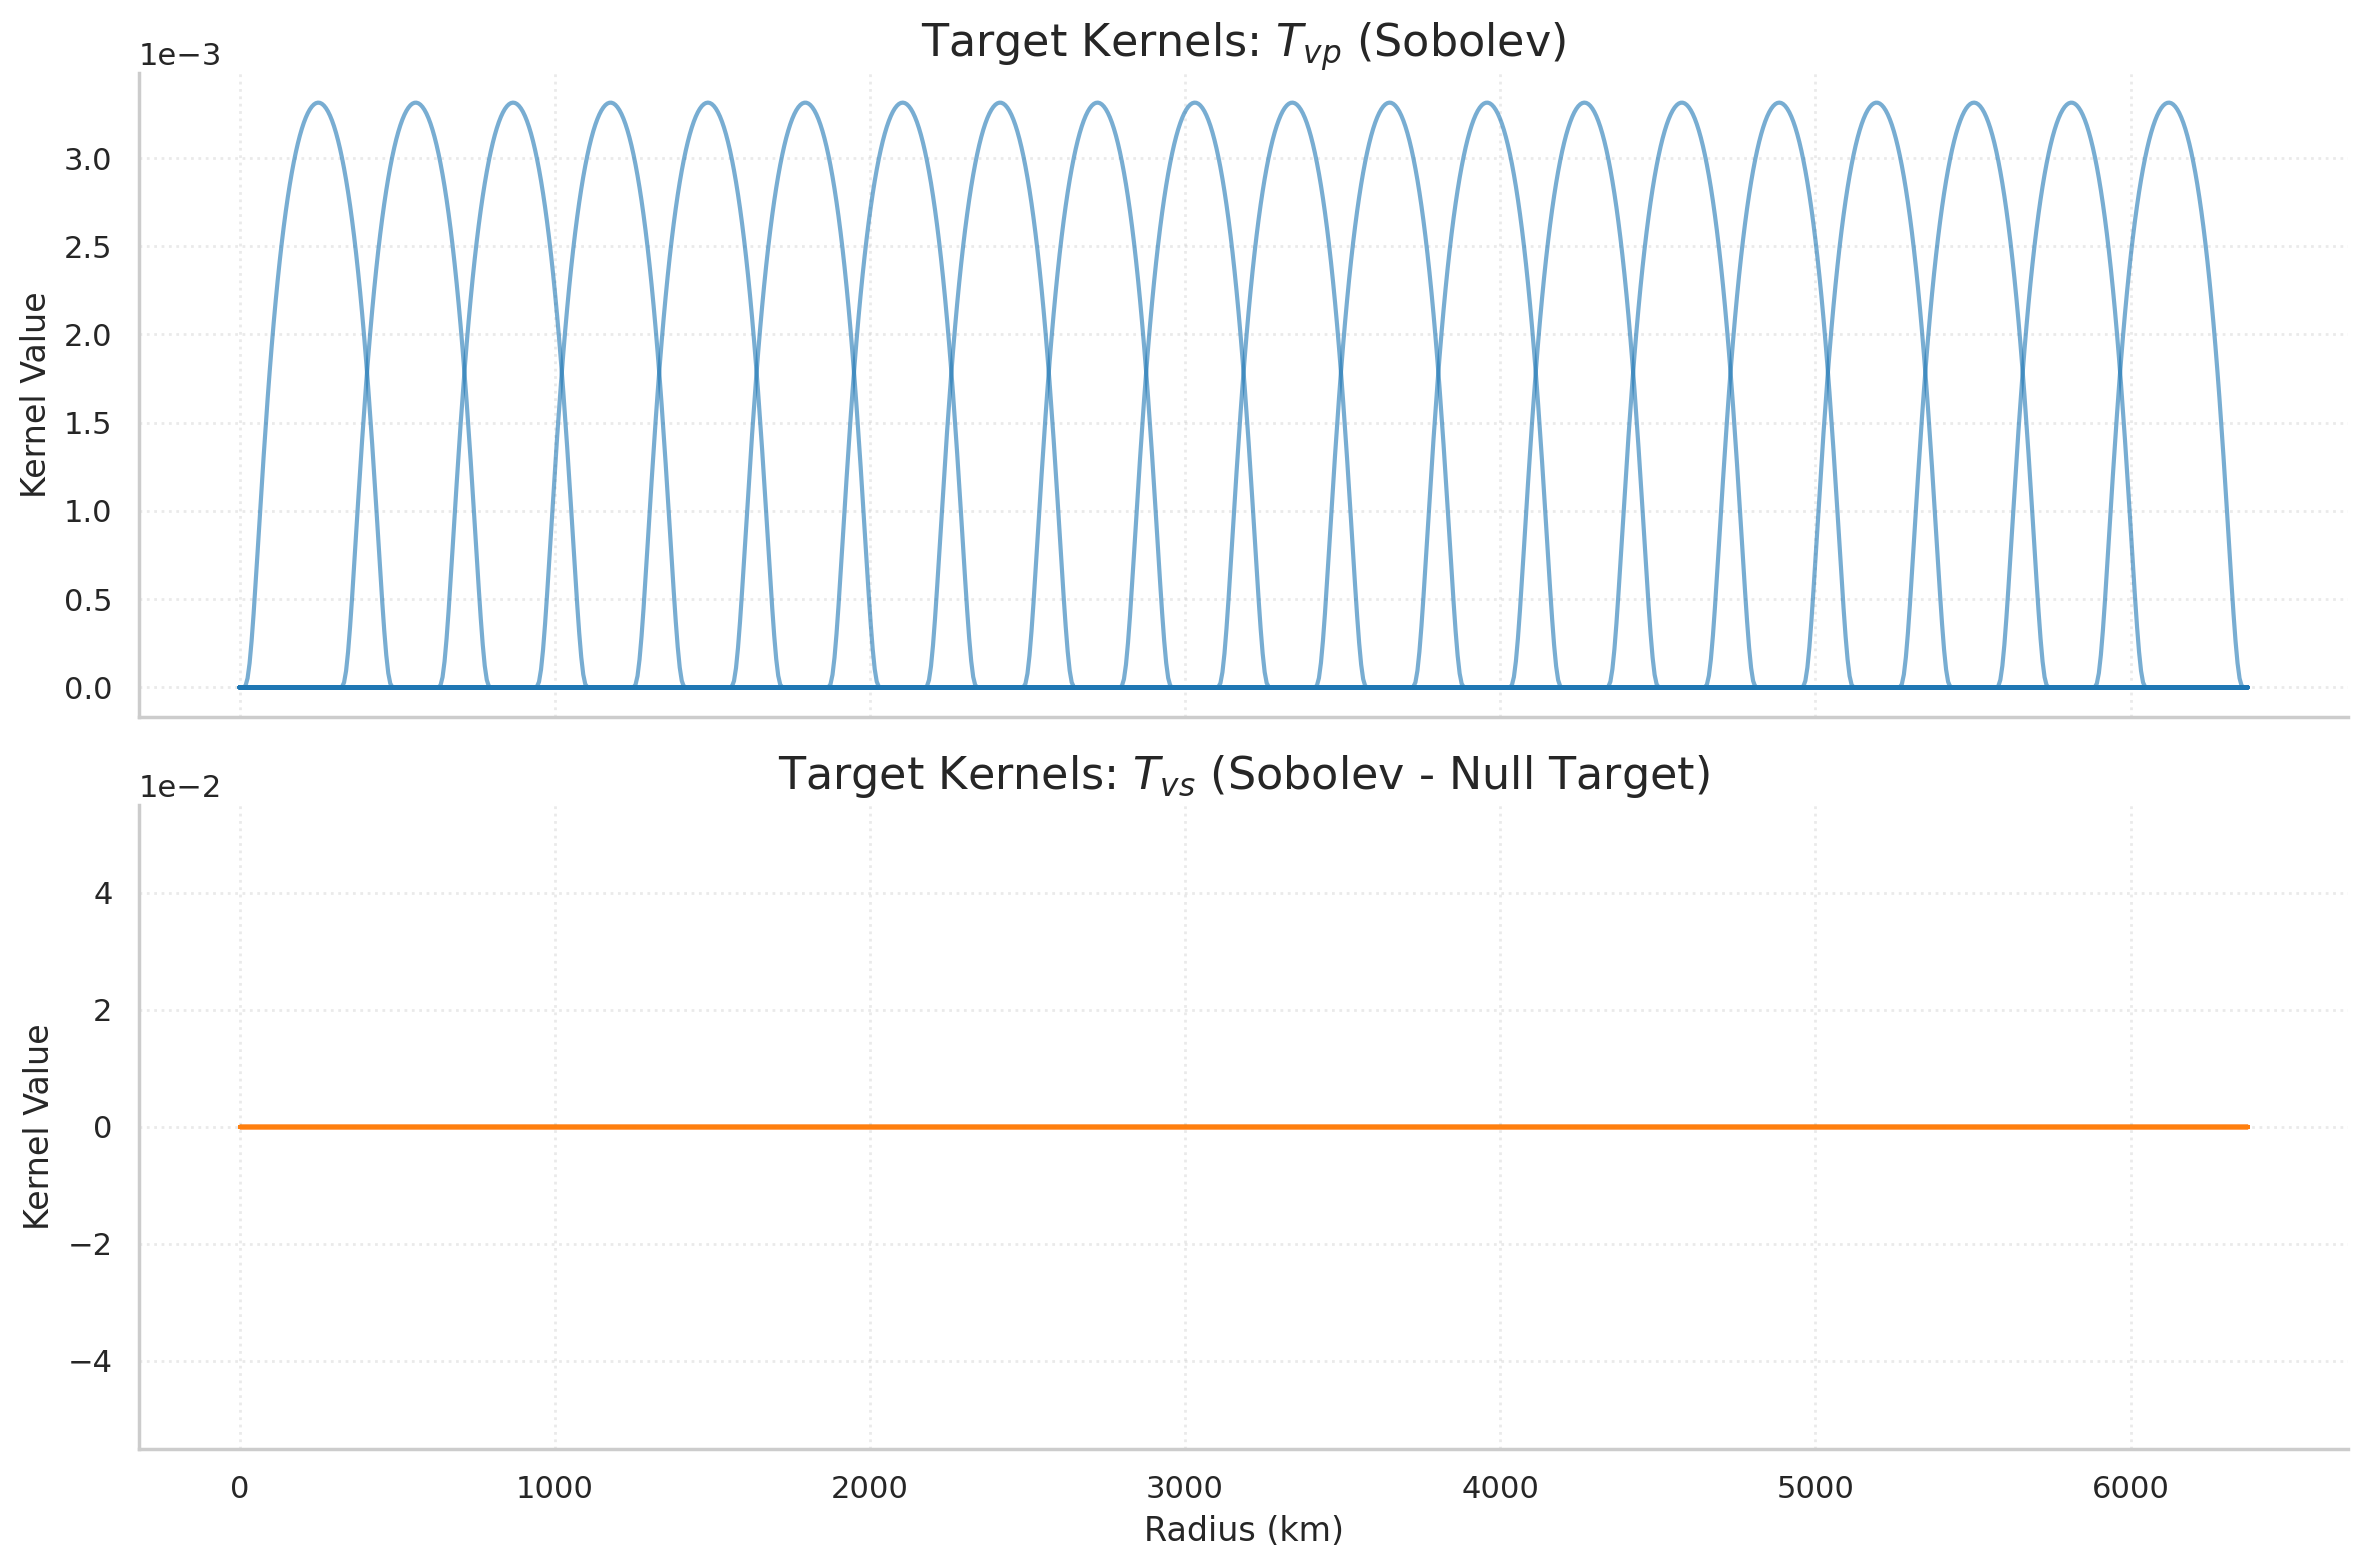


Visualization notes:
  - Top plot: 20 bump function targets for Vp
  - Bottom plot: Null targets for Vs (expected to be near-zero)
  - Each axis uses independent scaling to show actual amplitudes


In [123]:
# =============================================================================
# Target Kernels Visualization (Vp & Vs)
# =============================================================================
# This plot shows the target kernels (desired resolution functions) for both
# P-wave velocity (Vp) and S-wave velocity (Vs) components.
#
# NOTE: Vp uses bump function targets, while Vs uses null targets (zero).
# Each subplot has independent y-axis scaling to show actual amplitudes.
# =============================================================================

fig_title = "Target Kernels (vp & vs - Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Evaluation grid across the domain
x = np.linspace(function_domain.a, function_domain.b, 1000)

# Create two vertically stacked subplots with independent y-axes
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# ===== Top subplot: T_vp kernels (bump function targets) =====
axs[0].set_title(r"Target Kernels: $T_{vp}$ (Sobolev)", fontsize=16)
for i in range(N_p):
    axs[0].plot(
        x,
        T_vp.get_kernel(i).evaluate(x),
        color='tab:blue',
        alpha=0.6,
        linewidth=1.5,
    )
axs[0].set_ylabel("Kernel Value", fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)
# Use scientific notation for y-axis if values are very small
axs[0].ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

# ===== Bottom subplot: T_vs kernels (null targets - expect flat/zero) =====
axs[1].set_title(r"Target Kernels: $T_{vs}$ (Sobolev - Null Target)", fontsize=16)
for i in range(N_p):
    axs[1].plot(
        x,
        T_vs.get_kernel(i).evaluate(x),
        color='tab:orange',
        alpha=0.6,
        linewidth=1.5,
    )
axs[1].set_xlabel(r"Radius (km)", fontsize=12)
axs[1].set_ylabel("Kernel Value", fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)
# Use scientific notation for y-axis if values are very small
axs[1].ticklabel_format(axis='y', style='scientific', scilimits=(-2, 2))

sns.despine()
plt.tight_layout()

# Save figure in both PNG and PDF formats
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print information about what we're seeing
print(f"\nVisualization notes:")
print(f"  - Top plot: {N_p} bump function targets for Vp")
print(f"  - Bottom plot: Null targets for Vs (expected to be near-zero)")
print(f"  - Each axis uses independent scaling to show actual amplitudes")

Synthetic model configuration:
  Vp oscillation frequency: 5 cycles
  Vs oscillation frequency: 30 cycles
  Gaussian envelope width: 0.5 (fraction of domain)
  Discontinuity location: 50 km


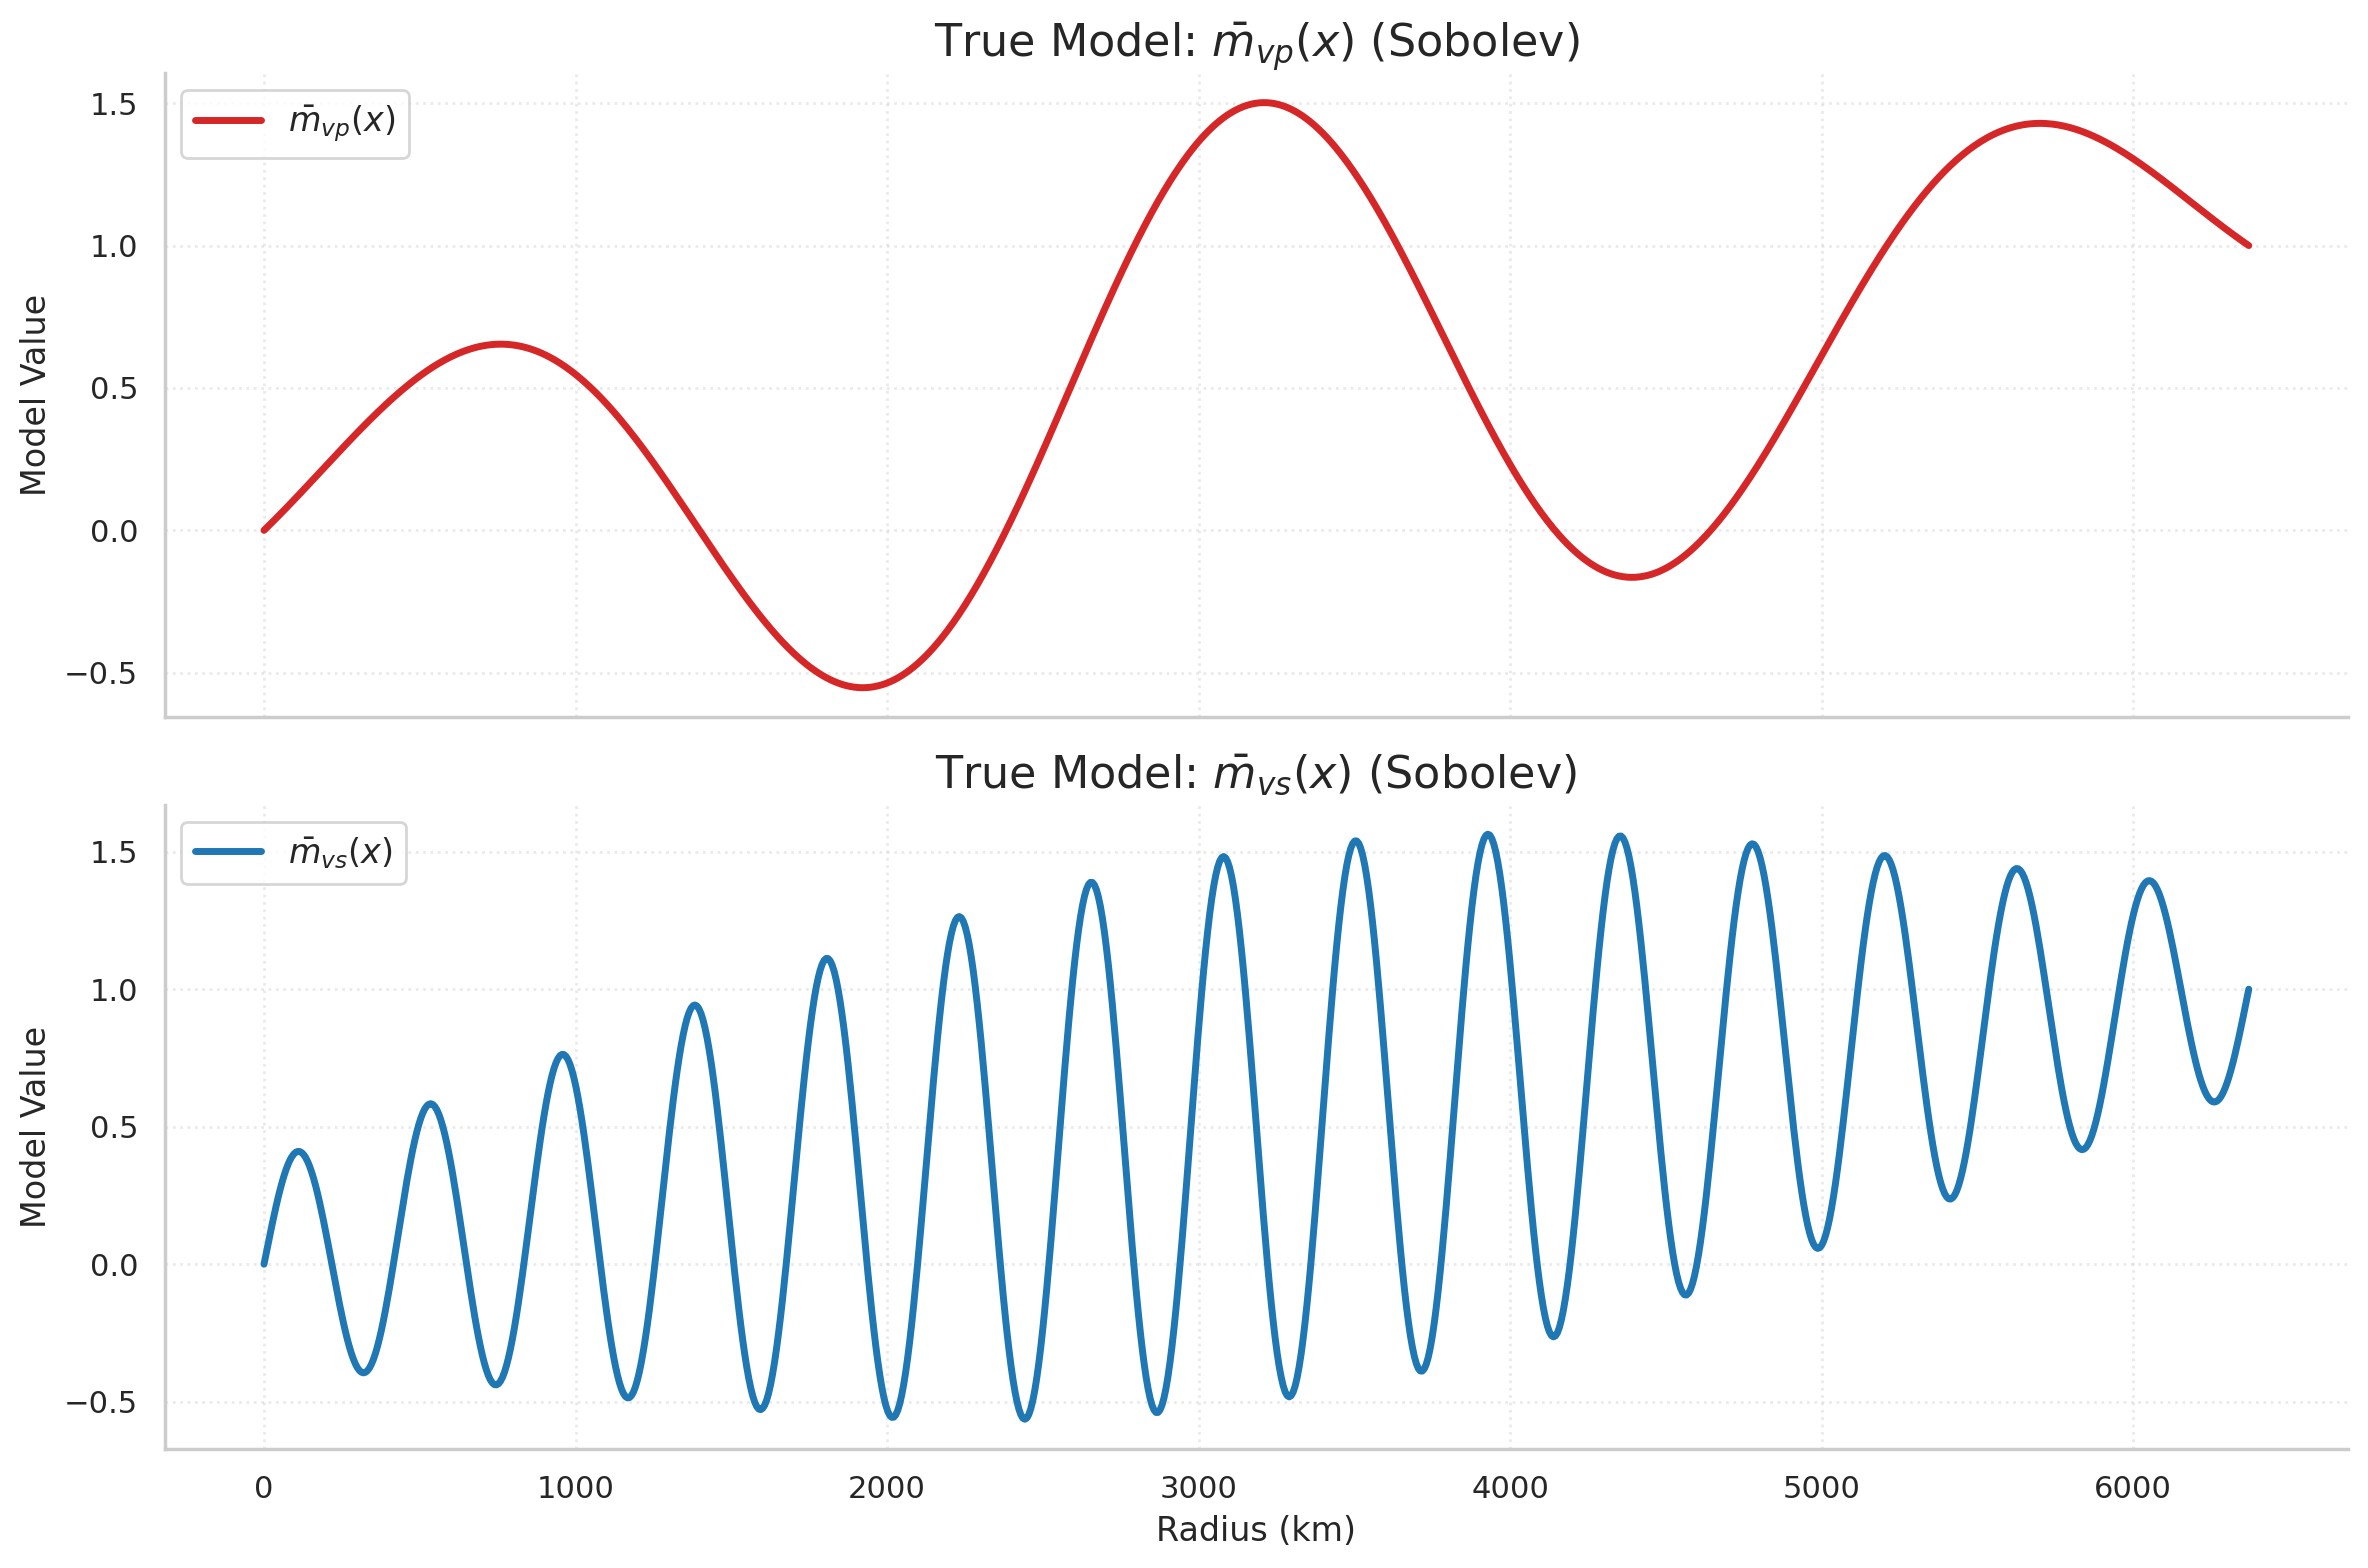


Generating synthetic data...
  Signal amplitude: 12184.5526
  Noise level: 1218.4553
  Signal-to-noise ratio: 10.0
  Number of observations: 50


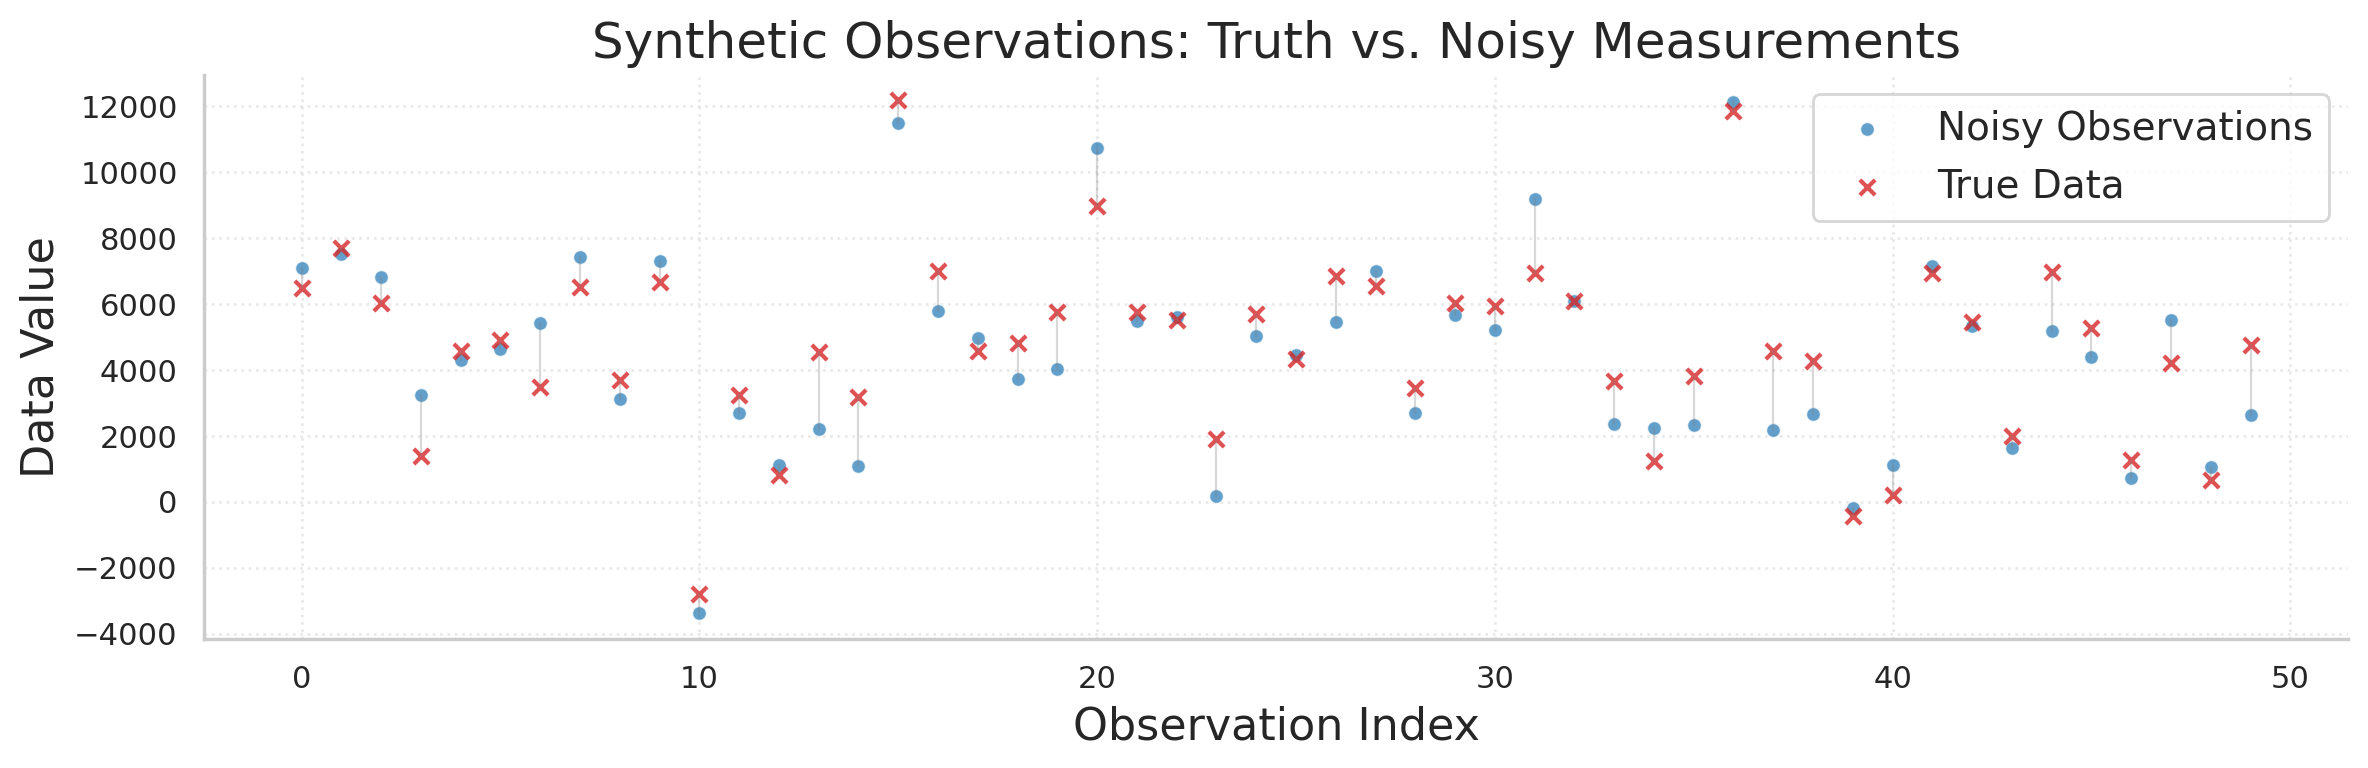

In [124]:
# =============================================================================
# Synthetic True Models
# =============================================================================
# Create synthetic true models for Vp, Vs, and discontinuity location
# These represent the "ground truth" we're trying to recover from noisy data
#
# Model structure:
# - Gaussian envelope: concentrates variation near domain center
# - Sinusoidal variation: adds oscillatory structure
# - Linear trend: adds smooth background variation
# =============================================================================

# Frequency parameters for oscillations
# Higher values = more wiggles across the domain
freq_vp = 5  # Number of oscillations for Vp (was 5, now 20 for more detail)
freq_vs = 30  # Number of oscillations for Vs (was 10, now 30 for more detail)

print(f"Synthetic model configuration:")
print(f"  Vp oscillation frequency: {freq_vp} cycles")
print(f"  Vs oscillation frequency: {freq_vs} cycles")
print(f"  Gaussian envelope width: 0.5 (fraction of domain)")
print(f"  Discontinuity location: 50 km")

# Define Vp true model: Gaussian envelope × oscillations + linear trend
m_bar_vp = Function(
    M_vp,
    evaluate_callable=lambda x: (
        np.exp(-(((x/function_domain.length) - 0.5)/0.5)**2) *
        np.sin(freq_vp * np.pi * (x/function_domain.length)) +
        (x/function_domain.length)
    )
)

# Define Vs true model: Similar structure with different frequency
m_bar_vs = Function(
    M_vs,
    evaluate_callable=lambda x: (
        np.exp(-(((x/function_domain.length) - 0.5)/0.5)**2) *
        np.sin(freq_vs * np.pi * (x/function_domain.length)) +
        (x/function_domain.length)
    )
)

# Discontinuity location (in km)
m_bar_discontinuity = 50.0

# Combine into full model structure
# Structure: [[function_components], scalar_component]
m_bar = [[m_bar_vp, m_bar_vs], m_bar_discontinuity]

# =============================================================================
# Visualization: True Models
# =============================================================================

x = np.linspace(function_domain.a, function_domain.b, 1000)

fig_title = "True Models (vp & vs - Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

sns.set_theme(style="whitegrid", palette="muted", color_codes=True)
fig, axs = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True)

# Top subplot: Vp true model
axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5, label=r'$\bar{m}_{vp}(x)$')
axs[0].set_title(r"True Model: $\bar{m}_{vp}(x)$ (Sobolev)", fontsize=16)
axs[0].set_ylabel('Model Value', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, linestyle=':', alpha=0.4)

# Bottom subplot: Vs true model
axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:blue', linewidth=2.5, label=r'$\bar{m}_{vs}(x)$')
axs[1].set_title(r"True Model: $\bar{m}_{vs}(x)$ (Sobolev)", fontsize=16)
axs[1].set_xlabel(r"Radius (km)", fontsize=12)
axs[1].set_ylabel('Model Value', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()

plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# =============================================================================
# Generate Synthetic Observations
# =============================================================================

print("\nGenerating synthetic data...")
d_bar = G(m_bar)

# Add realistic noise to the observations
noise_level = 0.1 * np.max(np.abs(d_bar))  # 10% of signal amplitude
np.random.seed(42)  # For reproducibility
d_tilde = d_bar + np.random.normal(0, noise_level, d_bar.shape)

print(f"  Signal amplitude: {np.max(np.abs(d_bar)):.4f}")
print(f"  Noise level: {noise_level:.4f}")
print(f"  Signal-to-noise ratio: {np.max(np.abs(d_bar)) / noise_level:.1f}")
print(f"  Number of observations: {len(d_tilde)}")

# =============================================================================
# Visualization: Synthetic Observations
# =============================================================================

fig_title = "Synthetic Observations (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(d_bar))

# Plot connection lines between true and noisy data
for i in range(len(d_bar)):
    plt.plot([i, i], [d_bar[i], d_tilde[i]], color='gray', alpha=0.3, linewidth=0.8)

# Plot the data points
plt.scatter(data_indices, d_tilde, label='Noisy Observations',
           color='tab:blue', alpha=0.7, marker='o', s=25, edgecolors='white', linewidths=0.5)
plt.scatter(data_indices, d_bar, label='True Data',
           color='tab:red', alpha=0.8, marker='x', s=30, linewidths=1.5)

plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.title('Synthetic Observations: Truth vs. Noisy Measurements', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

In [125]:
# Define data noise covariance
noise_variance = (0.1 * np.max(d_tilde))**2  # 10% of peak signal
C_D_matrix = noise_variance * np.eye(N_d)

print(f"Data noise standard deviation: {np.sqrt(noise_variance):.4f}")
print(f"Relative noise level: {100 * np.sqrt(noise_variance) / np.max(d_tilde):.1f}%")

# Create data NOISE measure (zero mean) for LinearForwardProblem
gaussian_D_noise = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=np.zeros(N_d))

# Create data measure (with observed data mean) for visualization
gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_tilde)

Data noise standard deviation: 1211.8756
Relative noise level: 10.0%


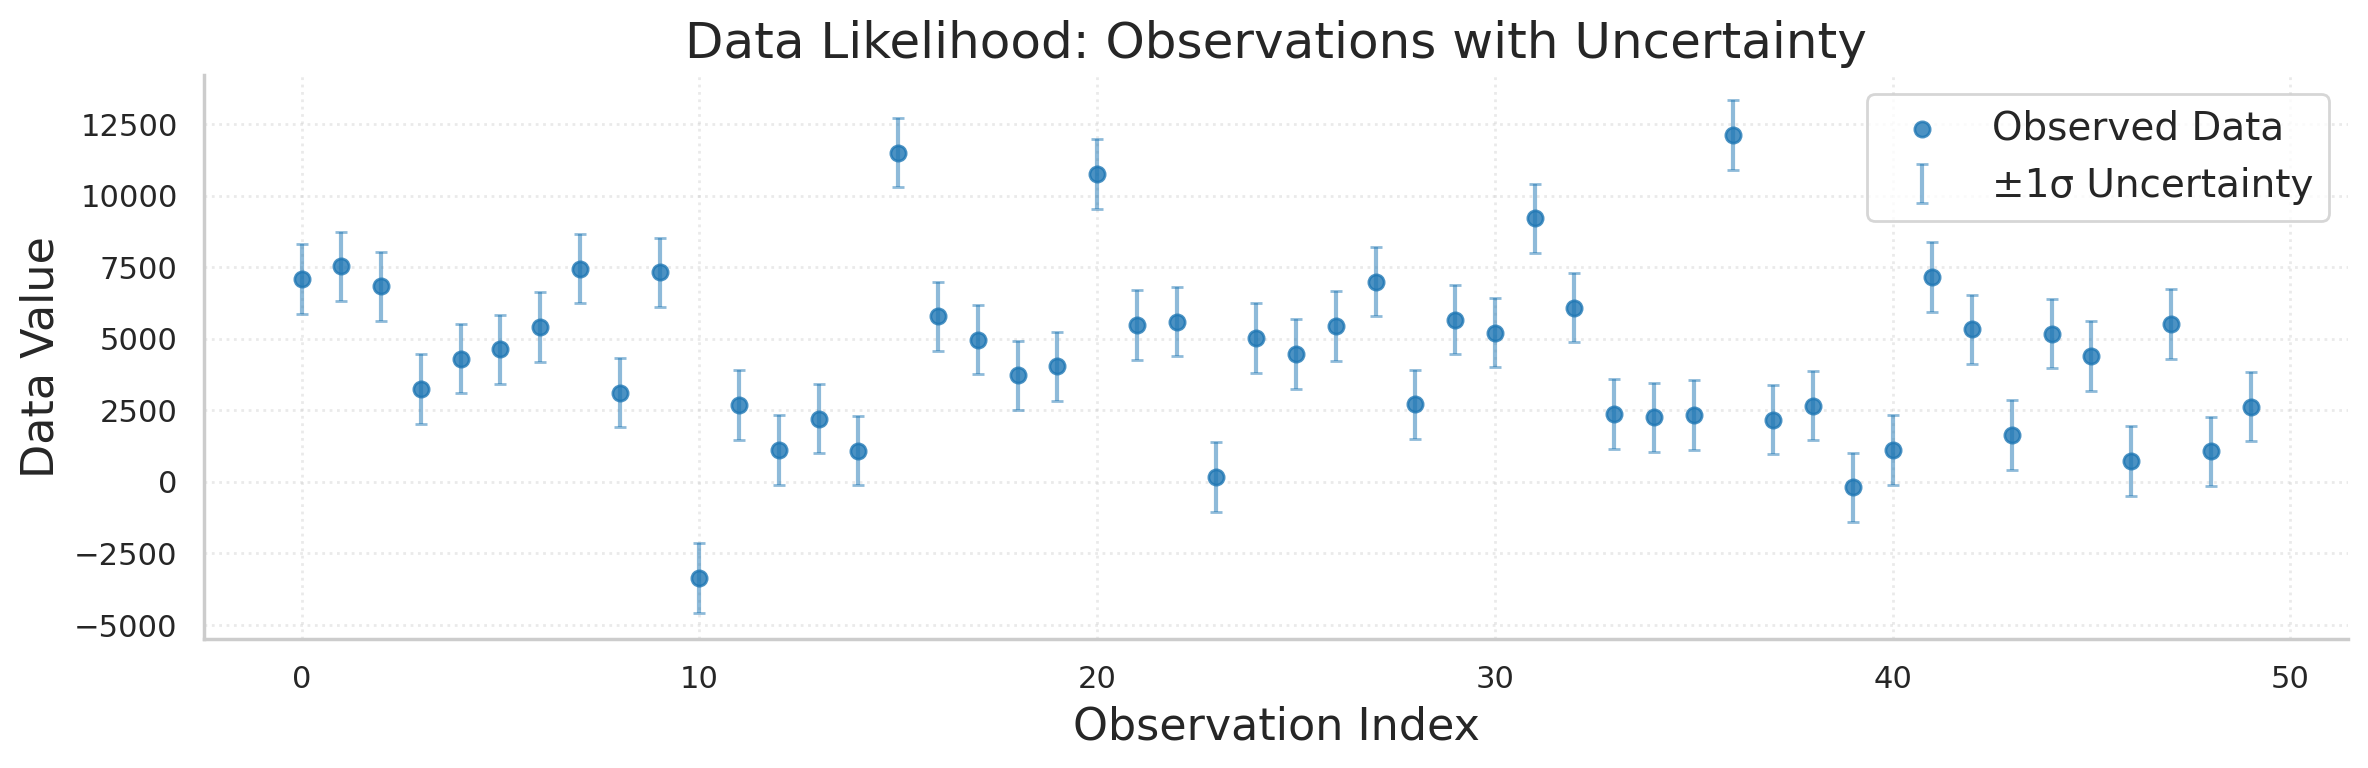

In [126]:
# Visualize the data measure
mean_values = gaussian_D.expectation
std_values = np.sqrt(noise_variance)

fig_title = "Data Likelihood Distribution (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 4), dpi=200)
data_indices = np.arange(len(mean_values))

plt.scatter(data_indices, mean_values, label='Observed Data', color='tab:blue', alpha=0.8, s=30)
plt.errorbar(data_indices, mean_values, yerr=std_values, fmt='none',
            color='tab:blue', alpha=0.5, capsize=2, capthick=1,
            label='±1σ Uncertainty')

plt.title("Data Likelihood: Observations with Uncertainty", fontsize=18)
plt.xlabel('Observation Index', fontsize=16)
plt.ylabel('Data Value', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

In [127]:
# =============================================================================
# Prior Measure Definition
# =============================================================================
# Define Gaussian prior measures for each component of the model space:
#   1. M_vp: Sobolev space for P-wave velocity
#   2. M_vs: Sobolev space for S-wave velocity
#   3. M_discontinuity: 1D Euclidean space for discontinuity location
#
# The prior encodes our beliefs about the model before seeing data.
# =============================================================================

print("="*80)
print("PRIOR MEASURE SETUP")
print("="*80)

# Import necessary classes
from pygeoinf.interval import BesselSobolevInverse
from pygeoinf.interval.KL_sampler import KLSampler

# Boundary conditions (shared between components)
bcs = BoundaryConditions(bc_type='neumann')

# ===== Vp Component Prior =====
print("\n1. Setting up Vp prior...")
alpha_vp = 0.1  # Laplacian regularization (smaller = rougher prior)
L_vp_prior = Laplacian(M_vp, bcs, alpha_vp, method='spectral', dofs=100, n_samples=2048)

# Smoothness parameters for Bessel-Sobolev
k_vp, s_vp = 1, 0.2  # k=order, s=smoothness parameter
C_0_vp = BesselSobolevInverse(M_vp, M_vp, k_vp, s_vp, L_vp_prior, dofs=100, n_samples=2048)

# Prior mean for Vp (linear trend)
m_0_vp = Function(M_vp, evaluate_callable=lambda x: x / function_domain.length)

print(f"   Prior covariance: BesselSobolevInverse(k={k_vp}, s={s_vp}, α={alpha_vp})")
print(f"   Boundary conditions: {bcs.type}")

# ===== Vs Component Prior =====
print("\n2. Setting up Vs prior...")
alpha_vs = 1.0  # Laplacian regularization (larger = smoother prior)
L_vs_prior = Laplacian(M_vs, bcs, alpha_vs, method='spectral', dofs=100, n_samples=2048)

# Smoothness parameters for Bessel-Sobolev
k_vs, s_vs = 1, 1.0  # More regularization for Vs
C_0_vs = BesselSobolevInverse(M_vs, M_vs, k_vs, s_vs, L_vs_prior, dofs=100, n_samples=2048)

# Prior mean for Vs (sinusoidal)
m_0_vs = Function(M_vs, evaluate_callable=lambda x: 0.1 * np.sin(2 * np.pi * x / function_domain.length))

print(f"   Prior covariance: BesselSobolevInverse(k={k_vs}, s={s_vs}, α={alpha_vs})")
print(f"   Boundary conditions: {bcs.type}")

# ===== Discontinuity Component Prior =====
print("\n3. Setting up discontinuity prior...")
# For the discontinuity location, use a simple Gaussian prior
discontinuity_prior_mean = 3185.5  # Center of domain (Earth's radius / 2)
discontinuity_prior_variance = 1000.0**2  # Large uncertainty (1000 km std dev)

# Covariance matrix for discontinuity (1x1 matrix)
C_0_discontinuity = discontinuity_prior_variance * np.eye(1)

print(f"   Prior mean: {discontinuity_prior_mean:.1f} km")
print(f"   Prior std dev: {np.sqrt(discontinuity_prior_variance):.1f} km")

# ===== Create Gaussian Measures with Samplers =====
print("\n4. Creating Gaussian measures...")

# Karhunen-Loève expansion for efficient sampling
K = 100  # Number of KL terms
print(f"   Using {K} Karhunen-Loève terms for function space sampling")

# Vp Gaussian measure with KL sampler
sampler_vp = KLSampler(C_0_vp, mean=m_0_vp, n_modes=K)
M_prior_vp = GaussianMeasure(covariance=C_0_vp, expectation=m_0_vp, sample=sampler_vp.sample)

# Vs Gaussian measure with KL sampler
sampler_vs = KLSampler(C_0_vs, mean=m_0_vs, n_modes=K)
M_prior_vs = GaussianMeasure(covariance=C_0_vs, expectation=m_0_vs, sample=sampler_vs.sample)

# Discontinuity Gaussian measure (simple Euclidean)
M_prior_discontinuity = GaussianMeasure.from_covariance_matrix(
    M_discontinuity,
    C_0_discontinuity,
    expectation=np.array([discontinuity_prior_mean])
)

# ===== Combine into Joint Prior =====
print("\n5. Combining into joint prior measure...")

# First combine the function spaces (Vp and Vs)
M_prior_sobolev = GaussianMeasure.from_direct_sum([M_prior_vp, M_prior_vs])

# Then combine with the discontinuity component
M_prior = GaussianMeasure.from_direct_sum([M_prior_sobolev, M_prior_discontinuity])

print(f"   Joint prior dimension: {M.dim}")
print(f"   - Vp component: {M_vp.dim}")
print(f"   - Vs component: {M_vs.dim}")
print(f"   - Discontinuity component: {M_discontinuity.dim}")

# ===== Display Eigenvalue Statistics =====
print("\n6. Eigenvalue decay analysis...")
eigenvals_vp = C_0_vp.get_eigenvalues(range(50))
eigenvals_vs = C_0_vs.get_eigenvalues(range(50))

print(f"   Vp eigenvalues: [{eigenvals_vp[-1]:.2e}, {eigenvals_vp[0]:.2e}]")
print(f"   Vp spectral decay: {eigenvals_vp[0]/eigenvals_vp[-1]:.1e}")
print(f"   Vs eigenvalues: [{eigenvals_vs[-1]:.2e}, {eigenvals_vs[0]:.2e}]")
print(f"   Vs spectral decay: {eigenvals_vs[0]/eigenvals_vs[-1]:.1e}")

print(f"\n{'='*80}")
print("PRIOR MEASURE SETUP COMPLETE")
print(f"{'='*80}")

PRIOR MEASURE SETUP

1. Setting up Vp prior...
   Prior covariance: BesselSobolevInverse(k=1, s=0.2, α=0.1)
   Boundary conditions: neumann

2. Setting up Vs prior...
   Prior covariance: BesselSobolevInverse(k=1, s=1.0, α=1.0)
   Boundary conditions: neumann

3. Setting up discontinuity prior...
   Prior mean: 3185.5 km
   Prior std dev: 1000.0 km

4. Creating Gaussian measures...
   Using 100 Karhunen-Loève terms for function space sampling

5. Combining into joint prior measure...
   Joint prior dimension: 41
   - Vp component: 20
   - Vs component: 20
   - Discontinuity component: 1

6. Eigenvalue decay analysis...
   Vp eigenvalues: [1.00e+00, 1.00e+00]
   Vp spectral decay: 1.0e+00
   Vs eigenvalues: [1.00e+00, 1.00e+00]
   Vs spectral decay: 1.0e+00

PRIOR MEASURE SETUP COMPLETE


In [128]:
# =============================================================================
# Check Forward Operator Balance
# =============================================================================
# Ensure that the contributions from Vp, Vs, and discontinuity are balanced
# so that no single component dominates the data
# =============================================================================

print("="*80)
print("FORWARD OPERATOR BALANCE CHECK")
print("="*80)

# Test with sample inputs
print("\nTesting operator magnitudes with sample inputs...")

# Sample from each component
sample_vp = M_prior_vp.sample()
sample_vs = M_prior_vs.sample()
sample_disc = M_prior_discontinuity.sample()

# Apply individual operators
data_vp = G_vp(sample_vp)
data_vs = G_vs(sample_vs)
data_disc = G_discontinuity(sample_disc)

# Compute magnitudes
mag_vp = np.linalg.norm(data_vp)
mag_vs = np.linalg.norm(data_vs)
mag_disc = np.linalg.norm(data_disc)

print(f"\nData space contributions (L2 norm):")
print(f"  From Vp:           {mag_vp:.2e}")
print(f"  From Vs:           {mag_vs:.2e}")
print(f"  From Discontinuity: {mag_disc:.2e}")

print(f"\nRelative magnitudes:")
print(f"  Vp/Discontinuity:  {mag_vp/mag_disc:.2f}")
print(f"  Vs/Discontinuity:  {mag_vs/mag_disc:.2f}")

# Check the actual data contributions
data_vp_true = G_vp(m_bar_vp)
data_vs_true = G_vs(m_bar_vs)
data_disc_true = G_discontinuity(np.array([m_bar_discontinuity]))

mag_vp_true = np.linalg.norm(data_vp_true)
mag_vs_true = np.linalg.norm(data_vs_true)
mag_disc_true = np.linalg.norm(data_disc_true)

print(f"\nTrue model contributions (L2 norm):")
print(f"  From Vp:           {mag_vp_true:.2e}")
print(f"  From Vs:           {mag_vs_true:.2e}")
print(f"  From Discontinuity: {mag_disc_true:.2e}")

print(f"\nRelative contributions:")
print(f"  Vp/Total:          {mag_vp_true/(mag_vp_true + mag_vs_true + mag_disc_true)*100:.1f}%")
print(f"  Vs/Total:          {mag_vs_true/(mag_vp_true + mag_vs_true + mag_disc_true)*100:.1f}%")
print(f"  Discontinuity/Total: {mag_disc_true/(mag_vp_true + mag_vs_true + mag_disc_true)*100:.1f}%")

if mag_disc_true < 0.01 * (mag_vp_true + mag_vs_true):
    print(f"\n⚠️  WARNING: Discontinuity contribution is very small!")
    print(f"   Consider increasing K_d (currently {K_d}) in the forward operator")
elif mag_disc_true > 10 * (mag_vp_true + mag_vs_true):
    print(f"\n⚠️  WARNING: Discontinuity contribution is very large!")
    print(f"   Consider decreasing K_d (currently {K_d}) in the forward operator")
else:
    print(f"\n✓ Forward operators are reasonably balanced")

print(f"{'='*80}")

FORWARD OPERATOR BALANCE CHECK

Testing operator magnitudes with sample inputs...

Data space contributions (L2 norm):
  From Vp:           9.68e+03
  From Vs:           9.29e+02
  From Discontinuity: 3.51e+05

Relative magnitudes:
  Vp/Discontinuity:  0.03
  Vs/Discontinuity:  0.00

True model contributions (L2 norm):
  From Vp:           1.32e+04
  From Vs:           1.35e+04
  From Discontinuity: 5.00e+03

Relative contributions:
  Vp/Total:          41.7%
  Vs/Total:          42.5%
  Discontinuity/Total: 15.8%

✓ Forward operators are reasonably balanced


Drawing samples from prior measure...
Computing prior uncertainty (vp)...
Computing prior uncertainty (vs)...


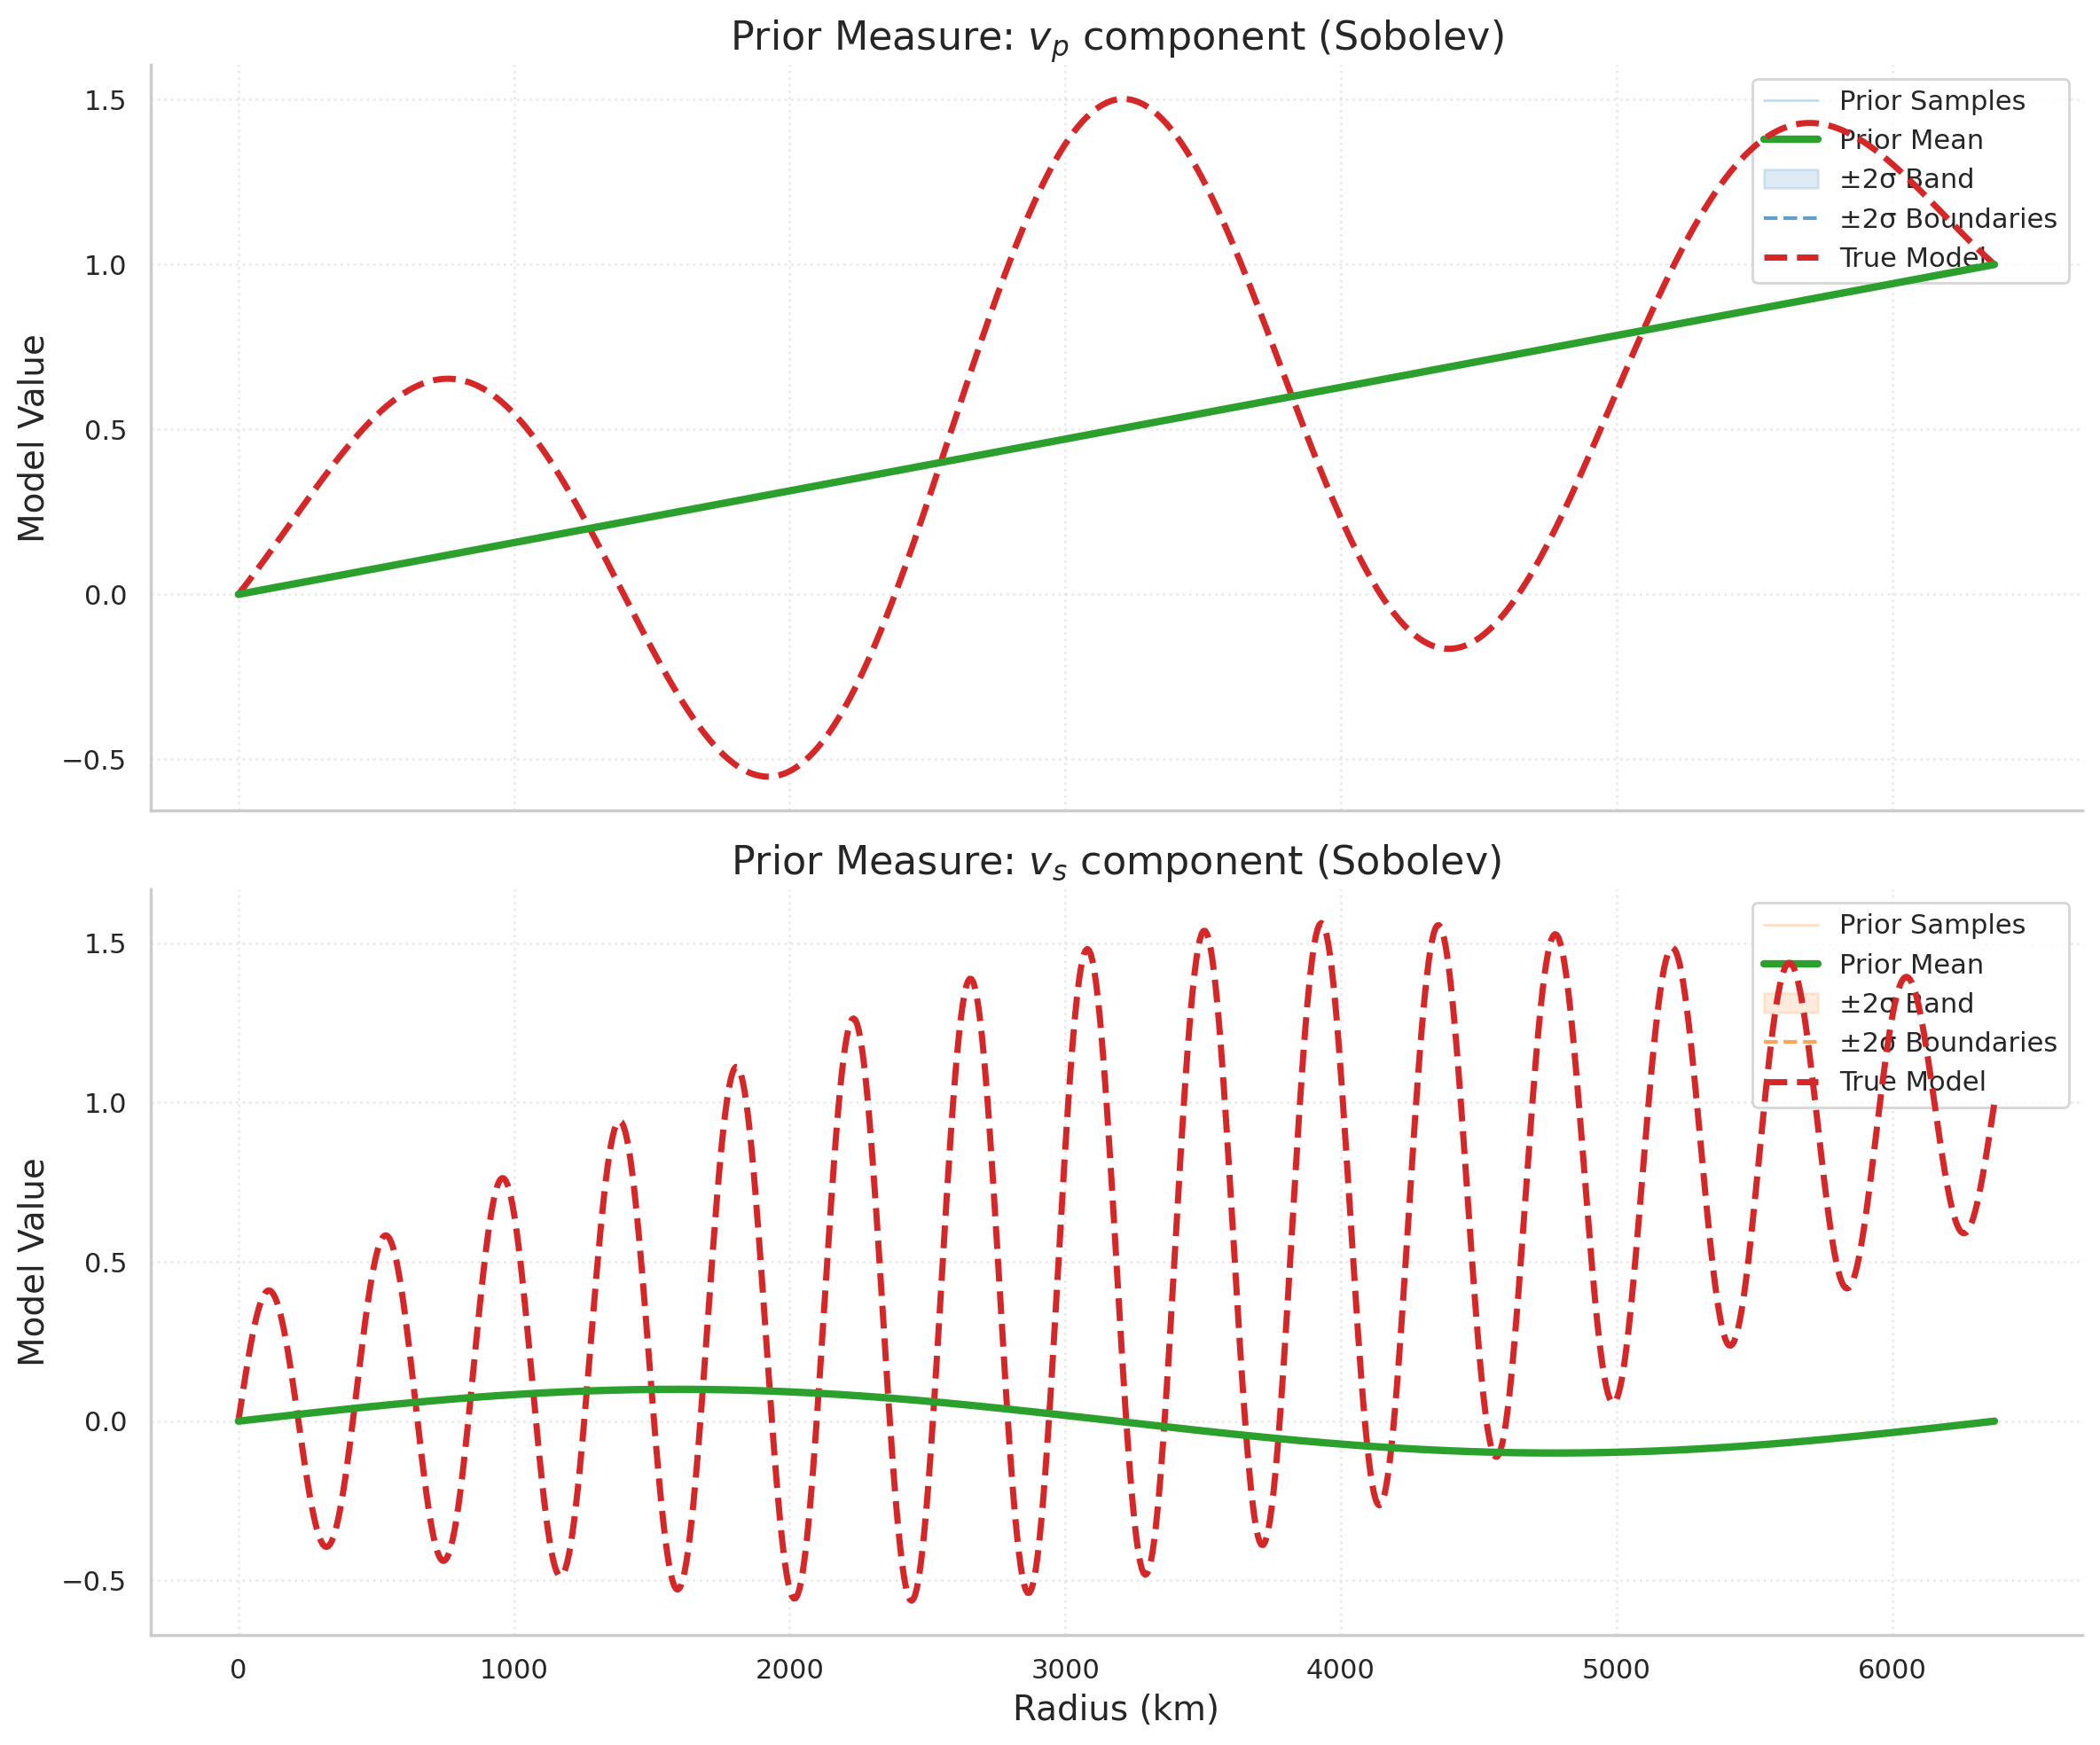


Discontinuity prior:
  Mean: 3185.5 km
  Std dev: 1000.0 km
  True value: 50.0 km
  True value within ±2σ: False


In [129]:
# =============================================================================
# Prior Measure Visualization
# =============================================================================
# Visualize samples from the prior measure for Vp and Vs components
# The discontinuity is scalar so we'll show its distribution separately
# =============================================================================

fig_title = "Prior Measure on Model Space (vp & vs - Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Parameters for visualization
num_samples = 15
sample_color_vp = 'tab:blue'
sample_color_vs = 'tab:orange'
mean_color = 'tab:green'
std_color_vp = 'tab:blue'
std_color_vs = 'tab:orange'

# Create two vertically stacked subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), dpi=200, sharex=True)

x = np.linspace(function_domain.a, function_domain.b, 1000)

# Plot prior samples
print("Drawing samples from prior measure...")
for i in range(num_samples):
    sample = M_prior.sample()
    # Unpack: [[vp, vs], discontinuity]
    sample_funcs, sample_disc = sample
    sample_vp, sample_vs = sample_funcs

    # Top subplot: vp
    axs[0].plot(x, sample_vp.evaluate(x), color=sample_color_vp, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "")

    # Bottom subplot: vs
    axs[1].plot(x, sample_vs.evaluate(x), color=sample_color_vs, alpha=0.25, linewidth=1,
                label='Prior Samples' if i == 0 else "")

# Compute uncertainty bounds for vp
print("Computing prior uncertainty (vp)...")
std_vp = M_vp.zero
for i, eigenvalue in enumerate(C_0_vp.get_eigenvalues(range(K))):
    eigenfunction = C_0_vp.get_eigenfunction(i)
    std_vp += eigenvalue * eigenfunction * eigenfunction
std_values_vp = np.sqrt(std_vp.evaluate(x))

# Compute uncertainty bounds for vs
print("Computing prior uncertainty (vs)...")
std_vs = M_vs.zero
for i, eigenvalue in enumerate(C_0_vs.get_eigenvalues(range(K))):
    eigenfunction = C_0_vs.get_eigenfunction(i)
    std_vs += eigenvalue * eigenfunction * eigenfunction
std_values_vs = np.sqrt(std_vs.evaluate(x))

# Get prior means
mean_funcs, mean_disc = M_prior.expectation
mean_vp, mean_vs = mean_funcs

# Plot prior mean and uncertainty for vp (top subplot)
mean_values_vp = mean_vp.evaluate(x)
axs[0].plot(x, mean_values_vp, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[0].fill_between(x, mean_values_vp - 2*std_values_vp, mean_values_vp + 2*std_values_vp,
                     color=std_color_vp, alpha=0.15, label='±2σ Band')
axs[0].plot(x, mean_values_vp + 2*std_values_vp, color=std_color_vp, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries')
axs[0].plot(x, mean_values_vp - 2*std_values_vp, color=std_color_vp, linestyle='--',
            alpha=0.7, linewidth=1.5)

# Plot true vp model
axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

axs[0].set_title(r"Prior Measure: $v_p$ component (Sobolev)", fontsize=16)
axs[0].set_ylabel("Model Value", fontsize=14)
axs[0].legend(fontsize=11, loc='upper right')
axs[0].grid(True, linestyle=':', alpha=0.4)

# Plot prior mean and uncertainty for vs (bottom subplot)
mean_values_vs = mean_vs.evaluate(x)
axs[1].plot(x, mean_values_vs, color=mean_color, linewidth=3, label='Prior Mean', zorder=10)
axs[1].fill_between(x, mean_values_vs - 2*std_values_vs, mean_values_vs + 2*std_values_vs,
                     color=std_color_vs, alpha=0.15, label='±2σ Band')
axs[1].plot(x, mean_values_vs + 2*std_values_vs, color=std_color_vs, linestyle='--',
            alpha=0.7, linewidth=1.5, label='±2σ Boundaries')
axs[1].plot(x, mean_values_vs - 2*std_values_vs, color=std_color_vs, linestyle='--',
            alpha=0.7, linewidth=1.5)

# Plot true vs model
axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:red', linewidth=2.5,
            label='True Model', linestyle='--', zorder=9)

axs[1].set_title(r"Prior Measure: $v_s$ component (Sobolev)", fontsize=16)
axs[1].set_xlabel("Radius (km)", fontsize=14)
axs[1].set_ylabel("Model Value", fontsize=14)
axs[1].legend(fontsize=11, loc='upper right')
axs[1].grid(True, linestyle=':', alpha=0.4)

sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print discontinuity prior info
print(f"\nDiscontinuity prior:")
print(f"  Mean: {mean_disc[0]:.1f} km")
print(f"  Std dev: {np.sqrt(C_0_discontinuity[0,0]):.1f} km")
print(f"  True value: {m_bar_discontinuity:.1f} km")
print(f"  True value within ±2σ: {abs(m_bar_discontinuity - mean_disc[0]) < 2*np.sqrt(C_0_discontinuity[0,0])}")

In [130]:
# =============================================================================
# Property Prior: Push Forward of Model Prior
# =============================================================================
# Compute the property prior by pushing the model prior through T
# This gives us prior beliefs about the local properties
# =============================================================================

print("Computing property prior measure...")
prior_P = M_prior.affine_mapping(operator=T)
std_P = np.sqrt(np.diag(prior_P.covariance.matrix(dense=True, parallel=True, n_jobs=8)))

print(f"Property prior computed for {N_p} target locations")
print(f"Property uncertainty range: [{std_P.min():.3f}, {std_P.max():.3f}]")

Computing property prior measure...


ValueError: shapes (20,) and (1,) not aligned: 20 (dim 0) != 1 (dim 0)

In [ ]:
# =============================================================================
# Visualize Property Prior
# =============================================================================

fig_title = "Property Prior Distribution (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

plt.figure(figsize=(12, 5), dpi=200)

# Property prior mean and uncertainty
mean_prop = T(M_prior.expectation)
plt.errorbar(centers, mean_prop, yerr=2*std_P, fmt='o', color='tab:blue',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Prior (mean ±2σ)')
plt.fill_between(centers, mean_prop - 2*std_P, mean_prop + 2*std_P,
                color='tab:blue', alpha=0.15)

# True property values
true_props = T(m_bar)
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=100, alpha=0.9, linewidths=3, zorder=10)

# Sample from property prior
sampled_props = prior_P.sample()
plt.scatter(centers, sampled_props, label='Prior Sample',
           color='tab:green', marker='s', s=50, alpha=0.7, zorder=5)

plt.xlabel('Target Location (km)', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Prior: Beliefs Before Data', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Print statistics
print(f"True properties range: [{true_props.min():.3f}, {true_props.max():.3f}]")
print(f"How many true properties are within prior ±2σ: {np.sum(np.abs(true_props - mean_prop) <= 2*std_P)}/{len(true_props)}")

In [ ]:
# =============================================================================
# Bayesian Inference Setup and Posterior Computation
# =============================================================================
# Compute the Bayesian posterior using the LinearBayesianInference class
# Two workflows available:
#   1. Compute model posterior, then push to property space (slower, shows model)
#   2. Compute property posterior directly (faster, skips model visualization)
# =============================================================================

from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
import time

print("="*80)
print("BAYESIAN INFERENCE")
print("="*80)

# Common setup
print("\nSetting up Bayesian inference problem...")
t0 = time.time()

forward_problem = LinearForwardProblem(
    forward_operator=G,
    noise_measure=gaussian_D_noise,
    model_space=M,
    data_space=D
)

bayesian_inference = LinearBayesianInference(
    forward_problem=forward_problem,
    prior_measure=M_prior
)

solver = CholeskySolver(parallel=True, n_jobs=8)
t1 = time.time()
print(f"   Setup time: {t1-t0:.3f}s")

if COMPUTE_MODEL_POSTERIOR:
    print("\n" + "="*80)
    print("WORKFLOW 1: Model Posterior → Property Posterior")
    print("="*80)

    # Compute model posterior
    print("\n1. Computing model posterior measure...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Extract dense matrix
    print("\n2. Extracting dense covariance matrix...")
    t4 = time.time()
    C_M_matrix = posterior_model.covariance.matrix(dense=True, parallel=True, n_jobs=8)
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Create sampling-capable measure
    print("\n3. Creating sampling-capable measure...")
    t6 = time.time()
    mu_M = GaussianMeasure.from_covariance_matrix(M, C_M_matrix, expectation=posterior_model.expectation)
    m_tilde = mu_M.expectation
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    # Compute property posterior by pushing model posterior
    print("\n4. Computing property posterior (via model)...")
    t8 = time.time()
    property_posterior = mu_M.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=8)
    t9 = time.time()
    print(f"   Time: {t9-t8:.3f}s")

    total_time = t9 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 1 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Dense matrix:      {(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Measure creation:  {(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")
    print(f"  Property posterior:{(t9-t8)/total_time*100:5.1f}%  ({t9-t8:.3f}s)")

else:
    print("\n" + "="*80)
    print("WORKFLOW 2: Property Posterior Directly (Skip Model)")
    print("="*80)

    # Compute model posterior mean only (no dense covariance)
    print("\n1. Computing model posterior (mean only)...")
    t2 = time.time()
    posterior_model = bayesian_inference.model_posterior_measure(d_tilde, solver)
    m_tilde = posterior_model.expectation
    t3 = time.time()
    print(f"   Time: {t3-t2:.3f}s")

    # Push to property space (fast - no dense matrices involved)
    print("\n2. Computing property posterior...")
    t4 = time.time()
    property_posterior = posterior_model.affine_mapping(operator=T)
    p_tilde = property_posterior.expectation
    t5 = time.time()
    print(f"   Time: {t5-t4:.3f}s")

    # Extract only the small property covariance matrix
    print("\n3. Extracting property covariance...")
    t6 = time.time()
    cov_P_matrix = property_posterior.covariance.matrix(dense=True, parallel=True, n_jobs=8)
    t7 = time.time()
    print(f"   Time: {t7-t6:.3f}s")

    total_time = t7 - t0
    print(f"\n{'='*80}")
    print(f"WORKFLOW 2 TOTAL TIME: {total_time:.3f}s")
    print(f"{'='*80}")
    print("\nBreakdown:")
    print(f"  Setup:             {(t1-t0)/total_time*100:5.1f}%  ({t1-t0:.3f}s)")
    print(f"  Model posterior:   {(t3-t2)/total_time*100:5.1f}%  ({t3-t2:.3f}s)")
    print(f"  Property posterior:{(t5-t4)/total_time*100:5.1f}%  ({t5-t4:.3f}s)")
    print(f"  Covariance extract:{(t7-t6)/total_time*100:5.1f}%  ({t7-t6:.3f}s)")

print(f"\n{'='*80}")
print("BAYESIAN INFERENCE COMPLETE")
print(f"{'='*80}")

In [ ]:
# =============================================================================
# Property Posterior Visualization
# =============================================================================
# Compare prior and posterior property distributions with true values
# =============================================================================

fig_title = "Property Posterior vs Prior (Sobolev)"
filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

# Extract posterior uncertainties
std_P_posterior = np.sqrt(np.diag(cov_P_matrix))

plt.figure(figsize=(14, 6), dpi=200)

# Plot prior
plt.errorbar(centers - 30, mean_prop, yerr=2*std_P, fmt='s', color='tab:blue',
            alpha=0.5, capsize=3, capthick=1.5, markersize=5,
            label='Property Prior (mean ±2σ)', linewidth=1.5)

# Plot posterior
plt.errorbar(centers + 30, p_tilde, yerr=2*std_P_posterior, fmt='o', color='tab:green',
            alpha=0.7, capsize=4, capthick=2, markersize=6,
            label='Property Posterior (mean ±2σ)', linewidth=2)

# Plot true properties
plt.scatter(centers, true_props, label='True Properties',
           color='tab:red', marker='x', s=150, alpha=0.9, linewidths=3, zorder=10)

plt.xlabel('Target Location (km)', fontsize=16)
plt.ylabel('Property Value', fontsize=16)
plt.title('Property Inference: Prior → Posterior', fontsize=18)
plt.legend(fontsize=14, loc='best')
plt.grid(True, linestyle=':', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
plt.show()

# Compute uncertainty reduction
uncertainty_reduction = (std_P - std_P_posterior) / std_P * 100
print(f"\nProperty posterior statistics:")
print(f"  Mean uncertainty reduction: {uncertainty_reduction.mean():.1f}%")
print(f"  Min uncertainty reduction:  {uncertainty_reduction.min():.1f}%")
print(f"  Max uncertainty reduction:  {uncertainty_reduction.max():.1f}%")

# Compute errors
prior_error = np.abs(mean_prop - true_props)
posterior_error = np.abs(p_tilde - true_props)

print(f"\nError statistics:")
print(f"  Prior RMSE:     {np.sqrt(np.mean(prior_error**2)):.4f}")
print(f"  Posterior RMSE: {np.sqrt(np.mean(posterior_error**2)):.4f}")
print(f"  Improvement:    {(1 - np.sqrt(np.mean(posterior_error**2))/np.sqrt(np.mean(prior_error**2)))*100:.1f}%")

# Check how many true properties are within uncertainty bounds
prior_within_2sigma = np.sum(prior_error <= 2*std_P)
posterior_within_2sigma = np.sum(posterior_error <= 2*std_P_posterior)

print(f"\nCalibration (properties within ±2σ):")
print(f"  Prior:     {prior_within_2sigma}/{N_p} ({prior_within_2sigma/N_p*100:.1f}%)")
print(f"  Posterior: {posterior_within_2sigma}/{N_p} ({posterior_within_2sigma/N_p*100:.1f}%)")

In [ ]:
# =============================================================================
# Model Posterior Visualization (if computed)
# =============================================================================
# Visualize the recovered model for Vp and Vs components
# =============================================================================

if COMPUTE_MODEL_POSTERIOR:
    fig_title = "Model Posterior (vp & vs - Sobolev)"
    filename = os.path.join(figures_folder, fig_title.replace(" ", "_").lower() + ".png")

    x = np.linspace(function_domain.a, function_domain.b, 1000)

    # Unpack posterior mean
    m_tilde_funcs, m_tilde_disc = m_tilde
    m_tilde_vp, m_tilde_vs = m_tilde_funcs

    # Create figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 10), dpi=200, sharex=True)

    # ===== Top: Vp component =====
    # True model
    axs[0].plot(x, m_bar_vp.evaluate(x), color='tab:red', linewidth=2.5,
                label='True Model', linestyle='--', alpha=0.8)

    # Prior mean
    axs[0].plot(x, m_0_vp.evaluate(x), color='tab:blue', linewidth=2,
                label='Prior Mean', linestyle=':', alpha=0.6)

    # Posterior mean
    axs[0].plot(x, m_tilde_vp.evaluate(x), color='tab:green', linewidth=2.5,
                label='Posterior Mean', zorder=5)

    axs[0].set_title(r"Model Posterior: $v_p$ component", fontsize=16)
    axs[0].set_ylabel('Model Value', fontsize=14)
    axs[0].legend(fontsize=12, loc='best')
    axs[0].grid(True, linestyle=':', alpha=0.4)

    # ===== Bottom: Vs component =====
    # True model
    axs[1].plot(x, m_bar_vs.evaluate(x), color='tab:red', linewidth=2.5,
                label='True Model', linestyle='--', alpha=0.8)

    # Prior mean
    axs[1].plot(x, m_0_vs.evaluate(x), color='tab:blue', linewidth=2,
                label='Prior Mean', linestyle=':', alpha=0.6)

    # Posterior mean
    axs[1].plot(x, m_tilde_vs.evaluate(x), color='tab:green', linewidth=2.5,
                label='Posterior Mean', zorder=5)

    axs[1].set_title(r"Model Posterior: $v_s$ component", fontsize=16)
    axs[1].set_xlabel('Radius (km)', fontsize=14)
    axs[1].set_ylabel('Model Value', fontsize=14)
    axs[1].legend(fontsize=12, loc='best')
    axs[1].grid(True, linestyle=':', alpha=0.4)

    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.savefig(filename.replace('.png', '.pdf'), bbox_inches='tight')
    plt.show()

    # Print discontinuity results
    print(f"\nDiscontinuity inference:")
    print(f"  Prior mean:     {discontinuity_prior_mean:.2f} km")
    print(f"  Posterior mean: {m_tilde_disc[0]:.2f} km")
    print(f"  True value:     {m_bar_discontinuity:.2f} km")
    print(f"  Posterior error: {abs(m_tilde_disc[0] - m_bar_discontinuity):.2f} km")

    # Compute model errors
    vp_prior_error_L2 = np.sqrt(np.mean((m_0_vp.evaluate(x) - m_bar_vp.evaluate(x))**2))
    vp_posterior_error_L2 = np.sqrt(np.mean((m_tilde_vp.evaluate(x) - m_bar_vp.evaluate(x))**2))

    vs_prior_error_L2 = np.sqrt(np.mean((m_0_vs.evaluate(x) - m_bar_vs.evaluate(x))**2))
    vs_posterior_error_L2 = np.sqrt(np.mean((m_tilde_vs.evaluate(x) - m_bar_vs.evaluate(x))**2))

    print(f"\nModel reconstruction errors (L2 norm):")
    print(f"  Vp prior error:     {vp_prior_error_L2:.4f}")
    print(f"  Vp posterior error: {vp_posterior_error_L2:.4f}")
    print(f"  Vp improvement:     {(1 - vp_posterior_error_L2/vp_prior_error_L2)*100:.1f}%")
    print(f"\n  Vs prior error:     {vs_prior_error_L2:.4f}")
    print(f"  Vs posterior error: {vs_posterior_error_L2:.4f}")
    print(f"  Vs improvement:     {(1 - vs_posterior_error_L2/vs_prior_error_L2)*100:.1f}%")

else:
    print("\nModel posterior visualization skipped (COMPUTE_MODEL_POSTERIOR = False)")
    print("To visualize model posterior, set COMPUTE_MODEL_POSTERIOR = True and re-run")

In [ ]:
# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "="*80)
print("PROBABILISTIC LINEAR INFERENCE - SUMMARY")
print("="*80)

print(f"\nProblem Configuration:")
print(f"  Model space dimension:    {M.dim}")
print(f"    - Vp (Sobolev):         {M_vp.dim}")
print(f"    - Vs (Sobolev):         {M_vs.dim}")
print(f"    - Discontinuity:        {M_discontinuity.dim}")
print(f"  Data space dimension:     {D.dim}")
print(f"  Property space dimension: {P.dim}")
print(f"  Domain:                   [{function_domain.a}, {function_domain.b}] km")

print(f"\nForward Operator Balance:")
print(f"  Vp contribution:          {mag_vp_true:.2e}")
print(f"  Vs contribution:          {mag_vs_true:.2e}")
print(f"  Discontinuity contrib.:   {mag_disc_true:.2e}")

print(f"\nPrior Configuration:")
print(f"  Vp: BesselSobolevInverse(k={k_vp}, s={s_vp}, α={alpha_vp})")
print(f"  Vs: BesselSobolevInverse(k={k_vs}, s={s_vs}, α={alpha_vs})")
print(f"  Discontinuity: Gaussian(μ={discontinuity_prior_mean:.1f} km, σ={np.sqrt(discontinuity_prior_variance):.1f} km)")

print(f"\nData Configuration:")
print(f"  Observations:             {N_d}")
print(f"  Noise level:              {noise_level:.4f}")
print(f"  Signal-to-noise ratio:    {np.max(np.abs(d_bar))/noise_level:.1f}")

print(f"\nInference Results:")
print(f"  Property RMSE reduction:  {(1 - np.sqrt(np.mean(posterior_error**2))/np.sqrt(np.mean(prior_error**2)))*100:.1f}%")
print(f"  Avg uncertainty reduction: {uncertainty_reduction.mean():.1f}%")
print(f"  Properties within ±2σ:    {posterior_within_2sigma}/{N_p} ({posterior_within_2sigma/N_p*100:.1f}%)")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")